In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

In [2]:
# Single Qubit Gates
single_qubit_gates = ["I", "X", "Y", "Z",
    "C_NXYZ", "C_NZYX", "C_XNYZ", "C_XYNZ", "C_XYZ", "C_ZNYX", "C_ZYNX", "C_ZYX",
    "H", "H_NXY", "H_NXZ", "H_NYZ", "H_XY", "H_XZ", "H_YZ",
    "S", "S_DAG",
    "SQRT_X", "SQRT_X_DAG", "SQRT_Y", "SQRT_Y_DAG", "SQRT_Z", "SQRT_Z_DAG"
]

# Two Qubit Clifford Gates
two_qubit_clifford_gates = [
    "CNOT", "CX", "CXSWAP", "CY", "CZ", "CZSWAP",
    "II", "ISWAP", "ISWAP_DAG",
    "SQRT_XX", "SQRT_XX_DAG", "SQRT_YY", "SQRT_YY_DAG", "SQRT_ZZ", "SQRT_ZZ_DAG",
    "SWAP", "SWAPCX", "SWAPCZ",
    "XCX", "XCY", "XCZ", "YCX", "YCY", "YCZ", "ZCX", "ZCY", "ZCZ"
]

# Noise Channels
noise_channels = [
    "CORRELATED_ERROR", "DEPOLARIZE1", "DEPOLARIZE2", "E", "ELSE_CORRELATED_ERROR",
    "HERALDED_ERASE", "HERALDED_PAULI_CHANNEL_1",
    "II_ERROR", "I_ERROR",
    "PAULI_CHANNEL_1", "PAULI_CHANNEL_2",
    "X_ERROR", "Y_ERROR", "Z_ERROR"
]

# Collapsing Gates
collapsing_gates = ["M", "MR", "MRX", "MRY", "MRZ", "MX", "MY", "MZ", "R", "RX", "RY", "RZ", 
                    "MXX", "MYY", "MZZ", "MPP", "SPP", "SPP_DAG"]

#others
others = ["REPEAT", "DETECTOR", "MPAD", "OBSERVABLE_INCLUDE", "QUBIT_COORDS", "SHIFT_COORDS", "TICK"]

# Helpers

In [3]:
def to_string(array):
    s = ''
    for i in array:
        s+=str(i)
    return s

def to_binary(m, n):
    m = bin(m)[2:]
    return '0'*(n-len(m))+m

In [4]:
def num_measurements(stim_circuit):
    return sum([stim_circuit[i].num_measurements for i in range(len(stim_circuit))])

def find_fail_path(protocol):
    node = protocol.root
    path = []
    circuit = stim.Circuit('')
    
    while node != "FAIL":
        
        next_node = random.sample(list(protocol[node]), 1)[0]
        check_function = protocol[node][next_node]['check']
        
        check_function = check_function.replace(node+'[-1]', "x")
        for i in protocol.check_functions.keys():
            check_function=check_function.replace(i, protocol.check_functions[i].__name__)
        f = eval(f"lambda x: {check_function}")

        if node in protocol.circuits:
            n = num_measurements(protocol.circuits[node])
            for gate in protocol.circuits[node]:
                circuit.append(gate)

            if check_function != "True":
                check_function_input = random.randint(0,2**n-1)
                while not f(check_function_input):
                    check_function_input = random.randint(0,2**n-1)

                path.extend(to_binary(check_function_input,n))

            
        node = next_node
        
        path = [int(i) for i in path]
    return path, circuit

In [5]:
def insert_errors(circuit, p):
    added_gates = 0
    n_gates = len(circuit)
    for n in range(n_gates):
        gate_name = circuit[n+added_gates].name
        targets = circuit[n+added_gates].targets_copy()
        targets_int = [i.value for i in targets]
        if gate_name in single_qubit_gates:
            instruction = 'DEPOLARIZE1({p})'.format(p=p)
            for i in targets_int:
                instruction=instruction+' '+str(i)
            circuit.insert(n+added_gates+1, stim.Circuit(instruction))
            added_gates+=1
        elif gate_name in two_qubit_clifford_gates:
            instruction = 'DEPOLARIZE2({p})'.format(p=p)
            for i in targets_int:
                instruction=instruction+' '+str(i)
            circuit.insert(n+added_gates+1, stim.Circuit(instruction))
            added_gates+=1
        elif gate_name in collapsing_gates:
            for i in range(len(targets_int)):
                instruction='DETECTOR rec[-{}]'.format(i+1)
                circuit.insert(n+added_gates+1, stim.Circuit(instruction))
                added_gates+=1
    return circuit

In [6]:
def dem2matrices(dem, n_detectors):
    
    """
    This function just extracts the data from the detector error model generated by stim.
    
    It returns a vector with the errors, and a matrix whose rows are the corresponding error locations.
    
    """
    
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):

            err_locs[i, int(j[1])]=1

    return errors, err_locs

def separate_errors(error_locations, n_detectors):
    
    """
    This function is used to make the sampling of errors more efficient.
    
    Given the error locations, it separates them according to the first error location caused by an error.
    It returns the array extracted, whose element i is the subset of all error locations whose first error
    is in position i, and the array extracted_indices, which just returns the index of the first element of
    element[i] in the original array of error locations.
    
    For example, for the given error locations array:
    
        array([[1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.]])
       
    extracted returns 
    
        [array([[1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0.]]),
 array([[0., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 1.]]),
 array([[0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 1.]]),
 array([[0., 0., 0., 1., 1.]]),
 array([], shape=(0, 5), dtype=float64)]
 
     with the corresponding extracted_indices [0, 6, 10, 12, 13]
    
    """

    extracted = [0]*n_detectors
    extracted_indices = [0]*n_detectors
    index = 0
    
    for ii in range(n_detectors):
        
        extracted_indices[ii]=index
        
        #find number of errors with first error location in postion ii
        index_new = sum(error_locations[index:,ii]==1)+index
        extracted[ii] = error_locations[index:index_new]
        
        index=index_new
        
    return extracted, extracted_indices

In [7]:
def load_data(key):
    
    n_detectors = key['n_detectors']
    detector_outcomes = key['detector_outcomes']
    error_locations = key['error_locations']
    extracted = key['extracted']
    extracted_indices = key['extracted_indices']
    error_combinations = key['error_combinations']
    
    return n_detectors, detector_outcomes, error_locations, extracted, extracted_indices, error_combinations
    
def update_cache(cache_key, path, circuit):
    # creates new entry for cache dictionary
    
    # Simulate circuit with arbitrarily small error rate, just to extract the dem
    dem = circuit.detector_error_model()
    error_rates, error_locations = dem2matrices(repr(dem),len(path))
    n_errors = len(error_rates)
    n_detectors = len(path)


    sampler = circuit.compile_sampler()
    noiseless_outcome = sampler.sample(shots=1) # Use a noiseless (here actually with p_phys=1e-10) execution to find the actual detector flips we want
    detector_outcomes = np.copy(path)

    extracted, extracted_indices = separate_errors(error_locations, n_detectors)

    cache_values = dict({'circuit':circuit, 
                         'n_detectors': n_detectors, 
                         'detector_outcomes':detector_outcomes,
                         'error_locations':error_locations, 
                         'extracted':extracted, 
                         'extracted_indices':extracted_indices,
                        'error_combinations':[]})
    return cache_values

In [13]:
def sample_errors(dep, sequence, eloc, extracted, extracted_indices):
    
    """
    
    This function samples possible error combinations that lead to the desired sequence of 
    detector flips. For a small number N of possible errors, this can be calculated exactly by
    simply running over all possible 2^N combinations, but this becomes inefficient for large N,
    where sampling becomes for appropriate.
    
    
    """

    path = np.copy(sequence)
    result = np.zeros(len(eloc)) # This array will represent an error combination with the desired sequence outcome

    for jj in range(dep): # For each of the detectors in the sequence, do:
        if result is not None: # If the sequence seems achievable with the error combination so far,
            if path[jj]==1 and len(extracted[jj])==0: # If, with the error combination so far, you need detector jj to be 1, but there no further error that can flip it,
                result = None #impossible path: no error can now activate the desired detectors

            else:
                if len(extracted[jj]) > 3: #ignore more than 3 errors in a single subcircuit (very little chance of occuring for small p_phys)
                    w_max = 3
                else:
                    w_max = len(extracted[jj])

                w = random.choice(np.arange(path[jj], w_max+1,2)) # If we want detector jj to be 1, we need to select either 1 or 3 errors that begin with detector jj. If 0, that's 0 or 2 errors.

                if w>0: # Just because random.sample doesn't work with w=0
                    locs = np.array(random.sample(sorted(np.arange(len(extracted[jj]))), w))+extracted_indices[jj] # The w errors that we sample
                    result[locs]=1
                    path=((path+np.sum(eloc[locs], axis=0))%2).astype(int) # Now, an error typically flips more than one detector, so we need to update our path to eliminate the detectors we already flipped,
                    # or equivalently, to un-flip a detector we might have flipped.

    return result


def sample_circuits(n_samples, protocol):
    
    cache = dict() # dictionary that will store the data for each circuit sampled from the fail_paths

    for _ in range(n_samples):

        path, circuit = find_fail_path(protocol) # sample another circuit
        print(path)
        circuit = insert_errors(circuit, 1e-10)
        cache_key = to_string(path) # the circuit will be identified by its measurement sequence, 
                                        # not by its index in paths
            
        # if new circuit, create entry for cache dictionary 
        if cache_key not in cache:
            cache_values=update_cache(cache_key, path, circuit)
            cache.update({cache_key: cache_values})
        
        # load data from entry in cache
        n_detectors, detector_outcomes, error_locations, extracted, extracted_indices, error_combinations = load_data(cache[cache_key])

        # finds a set of possible errors that result in desired error sequence
        error_set = sample_errors(n_detectors, detector_outcomes, error_locations, extracted, extracted_indices)# All generated error combinations

        # only include error set if it was successful
        if error_set is not None:
            error_combinations.append(error_set)
            
    return cache

def estimate_error_rate(protocol, n_samples):
    
    errors_p_phys = np.zeros(len(p_phys)) # array with the error rate for each p_phys

    cache=sample_circuits(n_samples, protocol)
        
    # Now apply the error combinations to the error rates we actually care about 
    
    for key in cache.keys():
        unique_error_combinations = np.unique(cache[key]['error_combinations'], axis=0) # Remove repeated combinations 
        
        # If there was at least one error combination generating the desired sequence
        if len(unique_error_combinations)>0: 
            
            for i in range(len(p_phys)):
                circuit = stim.Circuit(cache[key]['circuit'])
                circuit = insert_errors(circuit, p_phys[i])
                dem = circuit.detector_error_model()
                error_rates, error_locations = dem2matrices(repr(dem),cache[key]['n_detectors'])
                
                # Calculate the total error rate of all generated combinations for given circuit
                errors_p_phys[i]+= np.sum(np.prod(error_rates*unique_error_combinations+
                                                  (1-error_rates)*(1-unique_error_combinations), axis=1))  

    return errors_p_phys

# QSample

In [11]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)

ENC = stim.Circuit("""H 0 1 3
                    CNOT 0 4
                    CNOT 1 2
                    CNOT 3 5
                    CNOT 0 6
                    CNOT 3 4
                    CNOT 1 5
                    CNOT 0 2
                    CNOT 5 6
                    CNOT 4 7
                    CNOT 2 7
                    CNOT 5 7
                    M 7
                    """)

sz_123 = stim.Circuit("""CNOT 0 8
            CNOT 1 8
            CNOT 3 8
            CNOT 6 8
            M 8
            TICK
            """)

x_cor = stim.Circuit("""X 6
""" ) 
meas7 = stim.Circuit("\nTICK\nM 0 1 2 3 4 5 6\n")



k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[ENC, sz_123, meas7])
steane0.add_node('X_COR', circuit=x_cor)
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

[1, 0, 1, 0, 0, 1, 1, 0, 0]


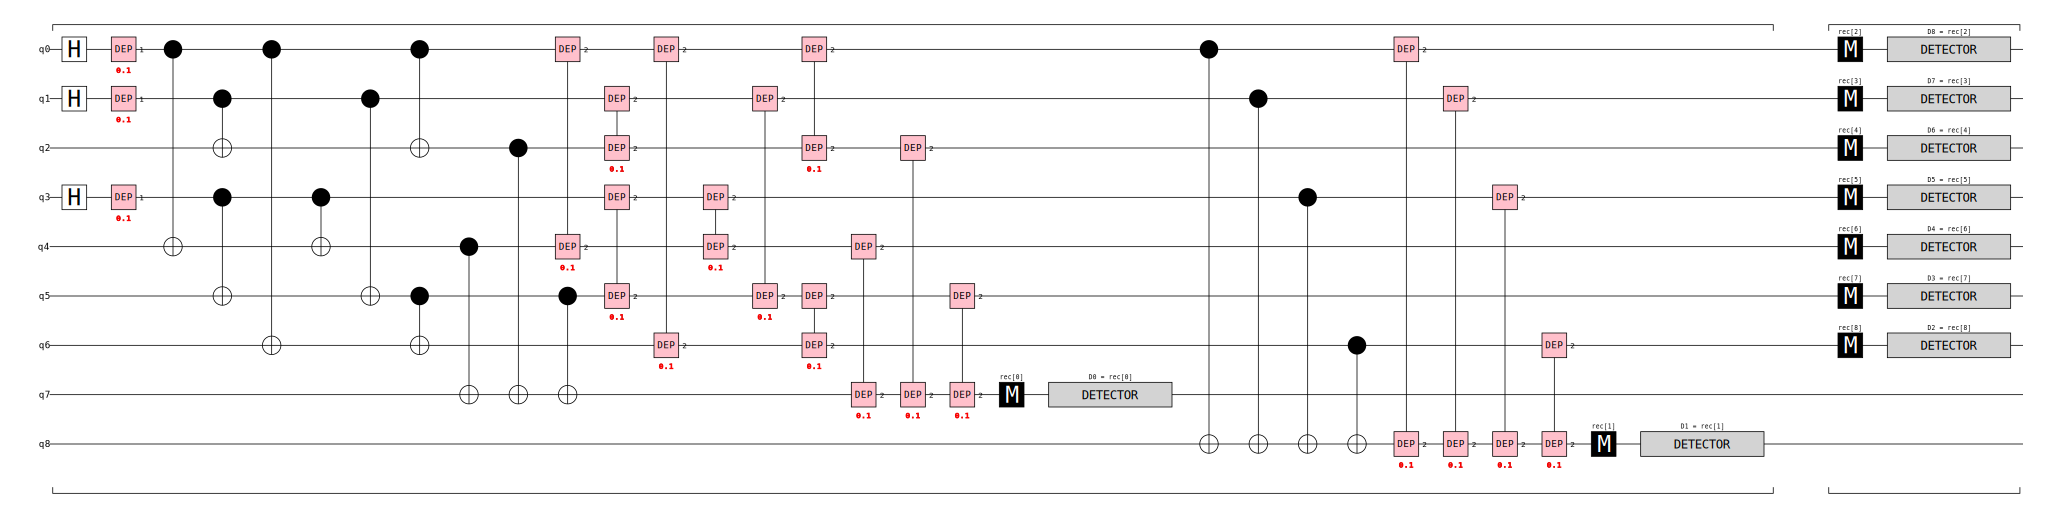

In [12]:
path, circuit = find_fail_path(steane0)
circuit = insert_errors(circuit, 0.1)
print(path)
circuit.diagram('timeline-svg')

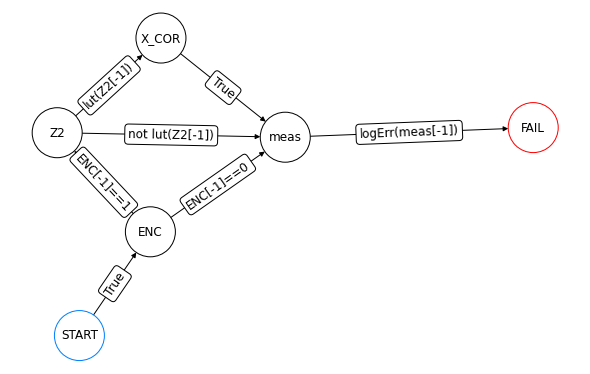

In [5]:
steane0.draw(figsize=(8,5))

In [15]:
err_model = qs.noise.E1
p_phys = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': p_phys}

# Comparison

In [16]:
begin = time.time()

all_errors = estimate_error_rate(steane0, 100)

end = time.time()
stim_time = end-begin

[1, 0, 0, 1, 0, 0, 1, 0, 1]


ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D2', 'D4', 'D6', 'D8', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D2:D4:D6:D8 > output_image.svg

This was discovered while analyzing qubit initialization into |0> at the start of the circuit on:
    qubit 0

The collapse anti-commuted with these detectors/observables:
    D2
    D4
    D6
    D8

The backward-propagating error sensitivity for D2 was:
    X0
    X1
    X3
    Z5
    Z6

The backward-propagating error sensitivity for D4 was:
    X0
    X3
    Z4

The backward-propagating error sensitivity for D6 was:
    X0
    X1
    Z2

The backward-propagating error sensitivity for D8 was:
    X0

/var/folders/dd/4yhpjrt92t3fr6_cq5glj9b80000gn/T/ipykernel_31192/2275812355.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


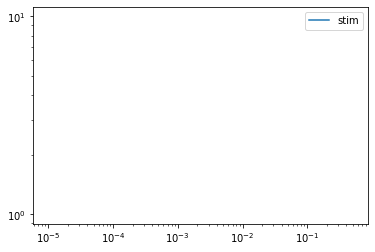

In [19]:
#plt.plot(p_phys, ss_sam.stats()[0], label = 'qsample, up')
#plt.plot(p_phys, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(p_phys, all_errors, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))
print(qsample_time/stim_time)